# Road Segmentation notebook

____

<div class="alert alert-block alert-success">
    
### Imports

In [98]:
from matplotlib import pyplot as plt
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger

import pandas as pd
import numpy as np



from unet import *
from constants import *
from data_preprocess import *
from data_postprocess import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
PATH_ROOT = ''
DATA_ROOT = PATH_ROOT+'data/'

<div class="alert alert-block alert-warning">

### Load Colab Notebook settings [COLAB]

**Link Google Drive** 

Upload your data `data` on your Google Drive in a directory called `ML`
 with inside subdirectories:

• `train`: with two sub directories of 400x400 images (`images` and `groundtruth`)

• `test`: with 608x608 images

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH_ROOT = 'gdrive/My Drive/ML/'  #change dir to your project folder
DATA_ROOT = PATH_ROOT+'data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Try GPU power**

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil, humanize, os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=9db872b0fb61bf1c5bde1931513606110c6e18d6c7a2ad8e64768dc612a3f3aa
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.5 GB  | Proc size: 534.2 MB
GPU RAM Free: 11372MB | Used: 69MB | Util   1% | Total 11441MB


**Kill GPU if not fast enought**

In [ ]:
#!kill -9 -1

### Train model
**1. Split data into validation and training directories**

In [68]:
create_validation_train_directory(DATA_ROOT+'train/',
                                  'images',
                                  'groundtruth', 1, 1)

24
96
24
96


**2. Data augmentation, generators, callbacks**

In [ ]:
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_generator = dataGenerator(2, DATA_ROOT+'train',
                                'images_tr',
                                'groundtruth_tr'
                                ,data_gen_args,
                                (SIDE,SIDE))

validation_generator = dataGenerator(2, DATA_ROOT+'train',
                                'images_te',
                                'groundtruth_te'
                                ,data_gen_args,
                                (SIDE,SIDE))

filepath = "weights.{epoch:02d}-{val_f1_m:.2f}.hdf5"

csv_logger = CSVLogger("AccuracyHistory.csv")
cp_callback = ModelCheckpoint(filepath=filepath, verbose=1, save_weights_only=True, period=1)

**3. Load the model** 

In [ ]:
model = unet256((SIDE,SIDE,3),lr=0.001, verbose=False)

**4. Train the model** 

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=200,#2000
                    epochs=100, #10
                    verbose=1,
                    validation_data = validation_generator,
                    validation_steps = 70,#700
                    validation_freq=1,
                    initial_epoch=0,
                    callbacks=[cp_callback, csv_logger]
                    )

Epoch 1/100
Found 24 images belonging to 1 classes.
Found 96 images belonging to 1 classes.
Found 24 images belonging to 1 classes.
Found 96 images belonging to 1 classes.
200/200 [==============================] - 147s 733ms/step - loss: 0.3936 - acc: 0.8013 - f1_m: 0.0382 - val_loss: 0.3935 - val_acc: 0.8240 - val_f1_m: 0.0021

Epoch 00001: saving model to weights.01-0.00.hdf5
Epoch 2/100
200/200 [==============================] - 128s 639ms/step - loss: 0.2735 - acc: 0.8724 - f1_m: 0.6146 - val_loss: 0.3458 - val_acc: 0.8900 - val_f1_m: 0.7026

Epoch 00002: saving model to weights.02-0.70.hdf5
Epoch 3/100
200/200 [==============================] - 128s 642ms/step - loss: 0.2222 - acc: 0.9073 - f1_m: 0.7417 - val_loss: 0.3059 - val_acc: 0.8839 - val_f1_m: 0.6899

Epoch 00003: saving model to weights.03-0.69.hdf5
Epoch 4/100
200/200 [==============================] - 128s 642ms/step - loss: 0.2028 - acc: 0.9158 - f1_m: 0.7613 - val_loss: 0.1772 - val_acc: 0.9296 - val_f1_m: 0.8057

Ep

### Save model to disk 

In [69]:
save_model(model, PATH_ROOT+"model_saved", "Model_UNET_256_k_fold_4_f1_975_rot_015_it_100x200")

OSError: Unable to create file (unable to open file: name = '../model_saved', errno = 21, error message = 'Is a directory', flags = 13, o_flags = 602)

____

### Predictions

**Load model** 

In [206]:
NAME_FILE = "Model_UNET_256_k_fold_4_f1_932_rot_90_it_120x200"
data_test = data_load(DATA_ROOT+'test_resized/')
model = unet256(input_size = (SIDE,SIDE,3), verbose=False)
model.load_weights(PATH_ROOT+"model_saved/"+NAME_FILE+".h5")

Image 50/50 is being loaded


**Resize images in a folder** 

In [207]:
reshape_img(DATA_ROOT+"test/", DATA_ROOT+"test_resized/", SIDE)

**Predict on test images and save the results**  

In [208]:
results = model.predict(data_test,verbose=1)

if not os.path.exists(DATA_ROOT+"predictions/"):
    os.mkdir(DATA_ROOT+"predictions/")
savePredictedImages(DATA_ROOT+"test_resized/", DATA_ROOT+"predictions/"+NAME_FILE+"a", results, concat=False)
savePredictedImages(DATA_ROOT+"test_resized/", DATA_ROOT+"predictions/"+NAME_FILE+"b", results, concat=True)

50/50 [==============================] - 138s 3s/step


______

**Resize image predictions to final size**

In [209]:
path_from = DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_4_f1_932_rot_90_it_120x200a/"
path_to = path_from
reshape_img(path_from, path_to, SIDE_FINAL)

**Load prediction before averaging them** 

In [222]:
original_data = data_load_for_prediction(DATA_ROOT+"test/", RGB_image=True)
IMGS = []
print("1-fold cross validation")
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_0_f1_874_rot_015_it_100x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_0_f1_799_rot_90_it_100x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_0_f1_802_rot_180_it_120x200a/")))
print("\n2-fold cross validation")
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_1_f1_905_rot_5_it_100x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_1_f1_815_rot_90_it_100x200_HVa/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_1_f1_841_rot_180_it_100x200a/")))
print("\n3-fold cross validation")
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_2_f1_914_rot_5_it_120x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_2_f1_892_rot_90_it_100x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_2_f1_887_rot180_it_100x200a/")))
print("\n4-fold cross validation")
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_3_f1_971_rot_5_it_200x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_3_f1_931_rot_90_it_200x120a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_3_f1_857_rot_180_it_120x200a/")))
print("\n5-fold cross validation")
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_4_f1_980_rot_5_it_120x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_4_f1_869_rot_180_it_120x200a/")))
IMGS.append((1, data_load_for_prediction(DATA_ROOT+"predictions/"+"Model_UNET_256_k_fold_4_f1_932_rot_90_it_120x200a/")))

means = average_image(IMGS)
print('Size should be (608, 608) and currently is:',means[0].shape)

Image 50/50 is being loaded
1-fold cross validation
Image 50/50 is being loaded
Image 50/50 is being loaded
Image 50/50 is being loaded

2-fold cross validation
Image 50/50 is being loaded
Image 50/50 is being loaded
Image 50/50 is being loaded

3-fold cross validation
Image 50/50 is being loaded
Image 50/50 is being loaded
Image 50/50 is being loaded

4-fold cross validation
Image 50/50 is being loaded
Image 50/50 is being loaded
Image 50/50 is being loaded

5-fold cross validation
Image 50/50 is being loaded
Image 50/50 is being loaded
Image 50/50 is being loaded
Size should be (50, 608, 608) and currently is: (50, 608, 608)
Size should be (608, 608) and currently is: (608, 608)


**Plot predictions**

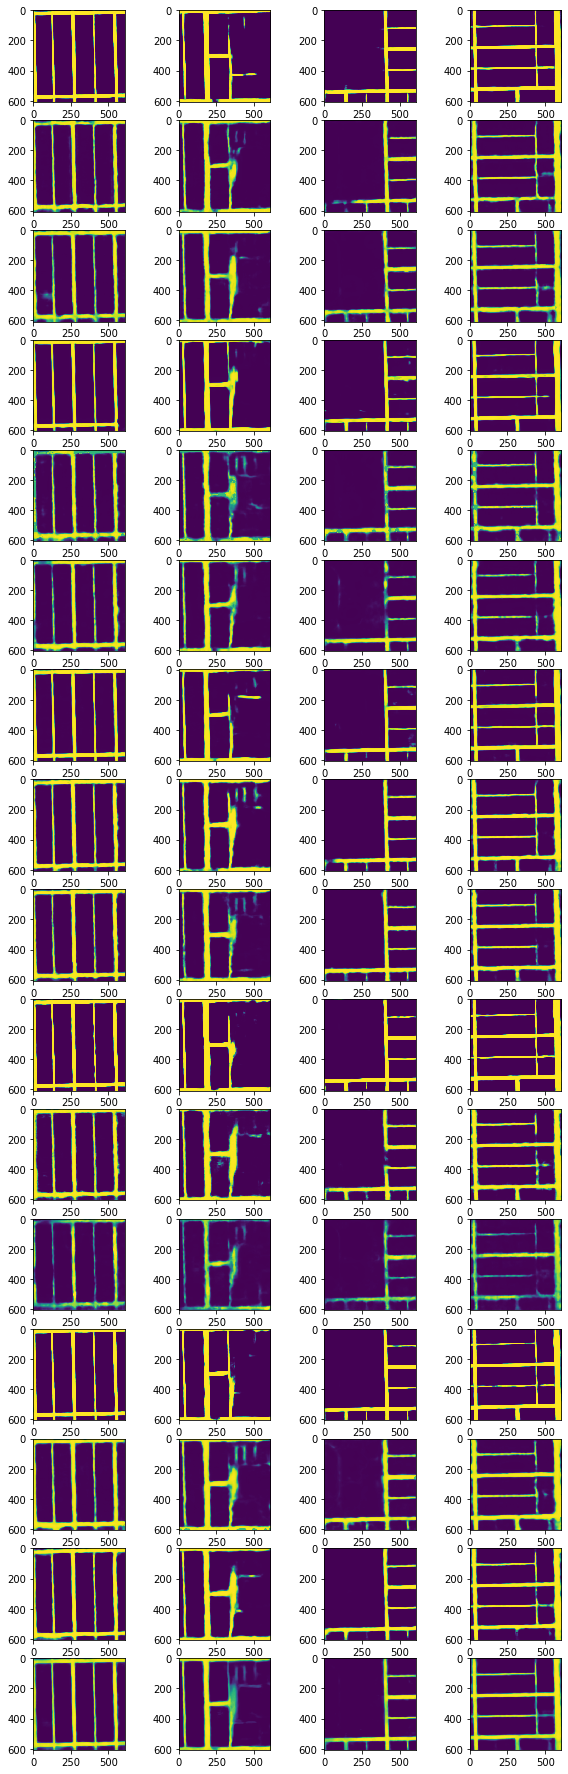

In [223]:
index_img = 30
columns = 4
rows = int(len(IMGS))+1

fig=plt.figure(figsize=(10, 2*rows))
img_to_plot = IMGS[0][1][index_img:index_img+4]
for i in range(1, int(len(IMGS))):
    img_to_plot = np.append(img_to_plot,IMGS[i][1][index_img:index_img+4], axis=0)
img_to_plot = np.append(img_to_plot, means[index_img:index_img+4], axis=0)
for i in range(1, columns*rows +1):
    img = img_to_plot[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [230]:
patched_imgs, vs = patched_imgs_and_vs(means)

Image 50/50 is being processed

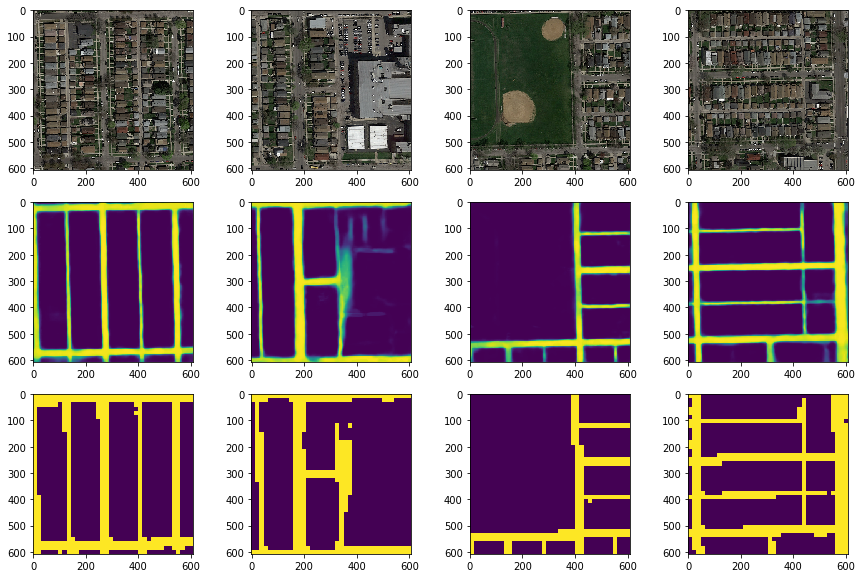

In [231]:
fig=plt.figure(figsize=(15, 10))
index_img = 30
columns = 4
rows = 3
img_to_plot0 = means[index_img:index_img+4]
img_to_plot1 =np.append(img_to_plot0, patched_imgs[index_img:index_img+4], axis=0)
for i in range(1, columns*rows +1):
    if(i<=4):
        img = original_data[index_img+i-1]
    else:
        img = img_to_plot1[i-5]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

**Create submissions**

In [232]:
if not os.path.exists(PATH_ROOT+"submissions/"):
        os.mkdir(PATH_ROOT+"submissions/")
create_csv_submission(patched_imgs, vs, PATH_ROOT+'submissions/k_fold_finito_without_weight_tresh025.csv')

### Plot du swwwwwaaaaggggg

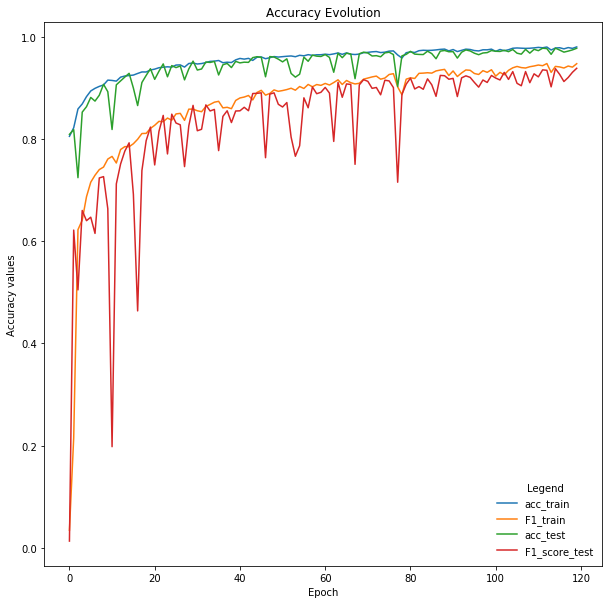

In [215]:
csv_file='../model_saved/AccuracyHistory90.csv'
data = pd.read_csv(csv_file)

epoch = data["epoch"]
acc_train = data["acc"]
F1_train = data["f1_m"]
loss_train = data["loss"]
acc_test = data["val_acc"]
F1_score_test = data["val_f1_m"]
loss_test = data["val_loss"]

x = list(epoch)
a = list(acc_train)
b = list(F1_train)
c = list(loss_train)
d = list(acc_test)
e = list(F1_score_test)
f = list(loss_test)

fig = plt.gcf()
fig.set_size_inches(10,10)
plt.plot(x,a)
plt.plot(x,b)
plt.plot(x,d)
plt.plot(x,e)
plt.xlabel('Epoch')
plt.ylabel('Accuracy values')
plt.title('Accuracy Evolution')
plt.legend(('acc_train','F1_train','acc_test','F1_score_test'),loc="lower right", title="Legend", frameon=False)
plt.show()

fig.savefig("Accuracy.png")